In [1]:
import sys
sys.path.append('../..')
from DLBio import pt_training
import ds_BA_falco
from torchvision.models.mobilenet import mobilenet_v2
import torch.nn as nn
from DLBio.pytorch_helpers import get_device, get_num_params
from DLBio.helpers import check_mkdir
from DLBio.pt_train_printer import Printer
import json
import matplotlib.pyplot as plt
from os.path import join
import numpy as np

In [2]:
class Classification(pt_training.ITrainInterface):
    def __init__(self, model, device):
        self.model = model
        self.xent_loss = nn.CrossEntropyLoss()
        self.metrics = {
            'acc': accuracy
        }
        self.d = device

    def train_step(self, sample):
        images, targets = sample[0].to(self.d), sample[1].to(self.d)
        pred = self.model(images)

        loss = self.xent_loss(pred, targets)
        metrics = dict()

        metrics.update({k: v(pred, targets) for k, v in self.metrics.items()})

        return loss, metrics


def accuracy(y_pred, y_true):
    _, y_pred = y_pred.max(1)  # grab class predictions
    return (y_pred == y_true).float().mean().item()

In [3]:
# define constants
FOLDER = './class_sample'
OPT_TYPE = 'Adam'
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.000001
EPOCHS = 10
LR_STEPS = 3
DO_EARLY_STOPPING = True
STOP_AFTER = 10
ES_METRIC = 'val_acc'
SAVE_INTERVALL = -1
PRINT_FREQUENCY = 500 # print every 500 batches
SEED = 0
BATCH_SIZE = 32
NUM_WORKERS = 1

# use seeds to ensure comparable results ()
pt_training.set_random_seed(SEED)

# apply to device
device = get_device()
print(device)
model = mobilenet_v2(pretrained=True)
model.fc = nn.Linear(1000,2)
model = model.to(device)

# definde folder to save model and log file
check_mkdir(FOLDER, is_dir=True)
model_out = join(FOLDER, 'model.pt')
log_file = join(FOLDER, 'log.json')

Setting seed: 0
cuda:0


In [4]:
# write some model specs
with open(join(FOLDER, 'model_specs.json'), 'w') as file:
    json.dump({
        'num_trainable': float(get_num_params(model, True)),
        'num_params': float(get_num_params(model, False))
    }, file)

# define indicies to split Data
N = len(ds_BA_falco.get_dataset())
n_80 = int(.8*N)
n_60 = int(.6*N)
n_20 = int(.2*N)

rand_indeces = np.random.permutation(N)
train_indeces = rand_indeces[:n_80]
valid_indeces = rand_indeces[n_80:]
#valid_indeces = rand_indeces[n_60:n_60+n_20]
#test_indeces = rand_indeces[n_60+n_20:]

# definde data loader
dl_train = ds_BA_falco.get_dataloader(
    indeces=train_indeces,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

dl_valid = ds_BA_falco.get_dataloader(
    indeces=valid_indeces,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

# dl_test = ds_BA_falco.get_dataloader(
#     indeces=test_indeces,
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_WORKERS
# )
# define optimizer
optimizer = pt_training.get_optimizer(
        'Adam', model.parameters(),
        LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )

if LR_STEPS > 0:
    scheduler = pt_training.get_scheduler(
            LR_STEPS, EPOCHS, optimizer)

if DO_EARLY_STOPPING:
    assert SAVE_INTERVALL == -1
    early_stopping = pt_training.EarlyStopping(
            ES_METRIC, get_max=True, epoch_thres=STOP_AFTER
        )
else:
    early_stopping = None
    
train_interface = Classification(model, device)

training = pt_training.Training(
        optimizer, dl_train, train_interface,
        scheduler=scheduler, printer=Printer(PRINT_FREQUENCY, log_file),
        save_path=model_out, save_steps=SAVE_INTERVALL,
        val_data_loader=dl_valid,
        early_stopping=early_stopping
    )

training(EPOCHS)


['falco', 'konrad']
['falco', 'konrad']
['falco', 'konrad']
Sched step size: 3
Ep: 0, loss: 9.48193 acc: 0.055 lr: 0.00010 sec: 0.60
saving model: ./class_sample/model.pt
Ep: 0, val_loss: 8.61537 val_acc: 0.000 lr: -1.00000 sec: 0.21
Ep: 1, loss: 5.08411 acc: 0.180 lr: 0.00010 sec: 0.58
saving model: ./class_sample/model.pt
Ep: 1, val_loss: 6.57552 val_acc: 0.031 lr: -1.00000 sec: 0.23
Ep: 2, loss: 2.14794 acc: 0.609 lr: 0.00010 sec: 0.57
saving model: ./class_sample/model.pt
Ep: 2, val_loss: 2.57136 val_acc: 0.531 lr: -1.00000 sec: 0.23
Ep: 3, loss: 0.82751 acc: 0.883 lr: 0.00001 sec: 0.52
saving model: ./class_sample/model.pt
Ep: 3, val_loss: 1.96592 val_acc: 0.594 lr: -1.00000 sec: 0.23
Ep: 4, loss: 0.72482 acc: 0.875 lr: 0.00001 sec: 0.55
saving model: ./class_sample/model.pt
Ep: 4, val_loss: 1.07494 val_acc: 0.875 lr: -1.00000 sec: 0.25
Ep: 5, loss: 0.92668 acc: 0.875 lr: 0.00001 sec: 0.61
Ep: 5, val_loss: 0.98738 val_acc: 0.812 lr: -1.00000 sec: 0.23
Ep: 6, loss: 0.67332 acc: 0.8

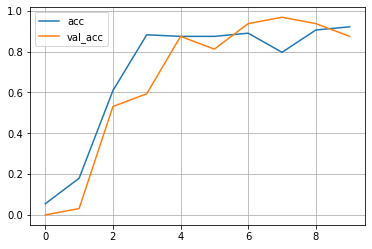

In [5]:
with open(log_file, 'r') as file:
    log = json.load(file)

plt.plot(log['acc'], label='acc')
plt.plot(log['val_acc'], label='val_acc')
plt.legend()
plt.grid()

In [6]:
model.eval

<bound method Module.eval of MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1